# Paremeter Set

In [134]:
num_days = 365 # วันที่ต้องการทำนาย

# Predict TEMP model

In [135]:
import pycaret
import pandas as pd

In [136]:
data = pd.read_csv('../export_data_jsp01/clean_data_jsps001_1d.csv')

In [ ]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)


แถวที่มีค่าหายไปก่อนเติม:
Empty DataFrame
Columns: [humidity, pm_2_5, temperature]
Index: []
ไม่มีค่าหายไปแล้ว


In [ ]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = num_days

# สร้างวันที่ใหม่
next_date = data.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data = pd.concat([data, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data = data.loc[~data.index.duplicated(keep='first')]


,humidity,pm_2_5,temperature,value
2026-02-02 07:00:00,NaN,NaN,NaN,395.0
2026-02-03 07:00:00,NaN,NaN,NaN,396.0
2026-02-04 07:00:00,NaN,NaN,NaN,397.0
2026-02-05 07:00:00,NaN,NaN,NaN,398.0
2026-02-06 07:00:00,NaN,NaN,NaN,399.0
2026-02-07 07:00:00,NaN,NaN,NaN,400.0
2026-02-08 07:00:00,NaN,NaN,NaN,401.0
2026-02-09 07:00:00,NaN,NaN,NaN,402.0
2026-02-10 07:00:00,NaN,NaN,NaN,403.0
2026-02-11 07:00:00,NaN,NaN,NaN,404.0


In [139]:
last_date_temp = data.index[-1].strftime('%Y-%m-%d')

In [140]:
data = data[['temperature']]

In [141]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'temperature_lag_{i}'] = data['temperature'].shift(i)


In [143]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [144]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)



In [145]:
from pycaret.regression import load_model, predict_model

model_temp = load_model("dt_jsps01_temp_model")

Transformation Pipeline and Model Successfully Loaded


In [146]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = last_date_temp

model = model_temp

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['temperature'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'temperature'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

## Plot Graph TEMP

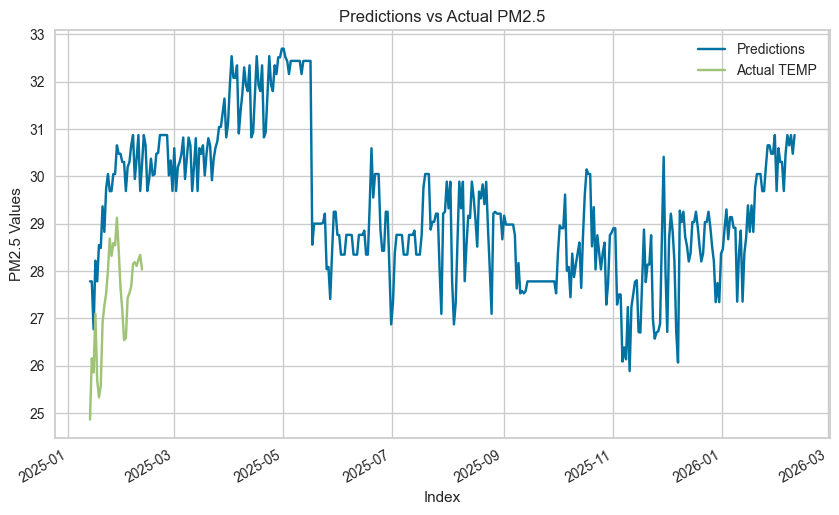

In [ ]:
#-------------TEMP PREDICT RESULT----------------------------
real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot_temp = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
result_plot_temp.columns = ['Predictions', 'Actual TEMP']  # ตั้งชื่อคอลัมน์


# Predict HUMI model

In [148]:
model_humi = load_model("br_humi_u_temp_model_jsps01")

Transformation Pipeline and Model Successfully Loaded


In [149]:
# อ่านไฟล์ CSV
data_humi = pd.read_csv('../export_data_jsp01/clean_data_jsps001_1d.csv')

# # ลบแถวล่าสุด (แถวสุดท้าย)
# data_humi = data_humi.drop(data_humi.index[-1])

In [150]:
data_humi.tail()

,timestamp,humidity,pm_2_5,temperature
1272,2025-02-07 07:00:00,72.053758,27.864365,28.186164
1273,2025-02-08 07:00:00,72.759274,33.923883,28.104894
1274,2025-02-09 07:00:00,69.850659,32.647832,28.231867
1275,2025-02-10 07:00:00,69.598712,32.856690,28.338313
1276,2025-02-11 07:00:00,71.713989,34.038326,28.029813


In [ ]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data_humi['timestamp'] = pd.to_datetime(data_humi['timestamp'])
data_humi.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data_humi = data_humi.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data_humi[data_humi.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data_humi.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data_humi[data_humi.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


แถวที่มีค่าหายไปก่อนเติม:
Empty DataFrame
Columns: [humidity, pm_2_5, temperature]
Index: []
ไม่มีค่าหายไปแล้ว


In [152]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = num_days

# สร้างวันที่ใหม่
next_date = data_humi.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data_humi = pd.concat([data_humi, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data_humi = data_humi.loc[~data_humi.index.duplicated(keep='first')]

data_humi.tail(10)

,humidity,pm_2_5,temperature,value
2026-02-02 07:00:00,NaN,NaN,NaN,395.0
2026-02-03 07:00:00,NaN,NaN,NaN,396.0
2026-02-04 07:00:00,NaN,NaN,NaN,397.0
2026-02-05 07:00:00,NaN,NaN,NaN,398.0
2026-02-06 07:00:00,NaN,NaN,NaN,399.0
2026-02-07 07:00:00,NaN,NaN,NaN,400.0
2026-02-08 07:00:00,NaN,NaN,NaN,401.0
2026-02-09 07:00:00,NaN,NaN,NaN,402.0
2026-02-10 07:00:00,NaN,NaN,NaN,403.0
2026-02-11 07:00:00,NaN,NaN,NaN,404.0


In [153]:
last_date_humi = data_humi.index[-1].strftime('%Y-%m-%d')

In [154]:
# add temp predict column
shifted_predictions_temp = result['prediction_label'].shift(-1).iloc[:-1]

data_humi.loc[shifted_predictions_temp.index, 'temperature'] = shifted_predictions_temp
data_humi.tail(10)

,humidity,pm_2_5,temperature,value
2026-02-02 07:00:00,NaN,NaN,30.303299,395.0
2026-02-03 07:00:00,NaN,NaN,30.303299,396.0
2026-02-04 07:00:00,NaN,NaN,29.689545,397.0
2026-02-05 07:00:00,NaN,NaN,30.476830,398.0
2026-02-06 07:00:00,NaN,NaN,30.872074,399.0
2026-02-07 07:00:00,NaN,NaN,30.655523,400.0
2026-02-08 07:00:00,NaN,NaN,30.872074,401.0
2026-02-09 07:00:00,NaN,NaN,30.476830,402.0
2026-02-10 07:00:00,NaN,NaN,30.872074,403.0
2026-02-11 07:00:00,NaN,NaN,NaN,404.0


In [155]:
data_humi = data_humi[['humidity','temperature']]

In [156]:
data_humi["year"] = data_humi.index.year
data_humi["month"] = data_humi.index.month
data_humi["day"] = data_humi.index.day
data_humi["day_of_week"] = data_humi.index.dayofweek  # 0 = Monday, 6 = Sunday
data_humi["week_of_year"] = data_humi.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data_humi มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data_humi["season"] = data_humi.index.month.map(assign_season)
data_humi['season'] = data_humi['season'].map(season_mapping)

data_humi["is_weekend"] = data_humi.index.dayofweek.isin([5, 6]).astype(int)

import pandas as pd
import numpy as np

# สมมุติว่ามี data_humiFrame data_humi ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data_humi['date'] = pd.to_datetime(data_humi[['year', 'month', 'day']])
data_humi['day_of_year'] = data_humi['date'].dt.dayofyear

lag_size = 7
for i in range(1,lag_size+1):
    data_humi[f'humidity_lag_{i}'] = data_humi['humidity'].shift(i)

for i in range(1,lag_size+1):
    data_humi[f'temperature_lag_{i}'] = data_humi['temperature'].shift(i)

In [157]:
data_filtered = data_humi.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [158]:
data_compare = data_filtered.loc[:'2025-01-12']
result_humi = pd.DataFrame()

start_date = "2025-01-13"
end_date = last_date_humi

model = model_humi

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'humidity_lag_{i}'] = data_compare['humidity'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['humidity'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'humidity'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result_humi
    result_humi = pd.concat([result_humi, predict_test_1], axis=0)

## Plot Graph HUMI

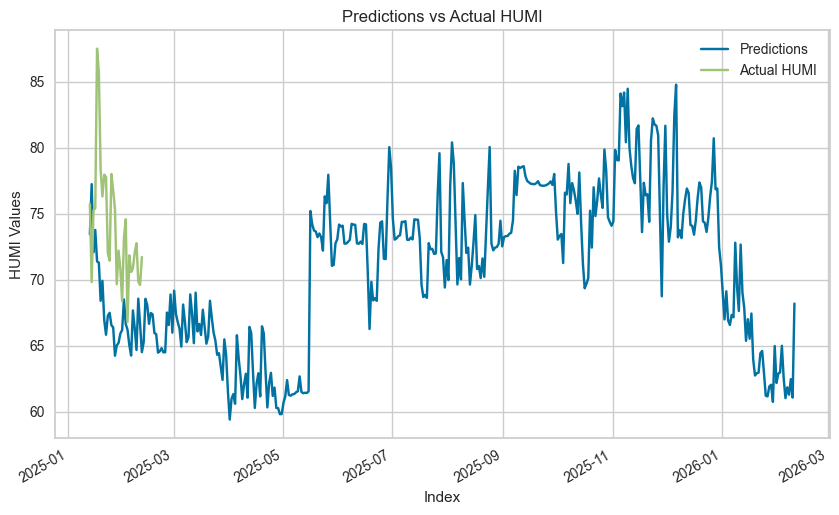

In [ ]:
#---------------------------Plot predict HUMI-----------------------
real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot_humi = pd.concat([result_humi['prediction_label'].shift(-1), real_data['humidity']], axis=1)
result_plot_hu_mi.columns = ['Predictions', 'Actual HUMI']  # ตั้งชื่อคอลัมน์


# Predict PM2.5

In [160]:
model_pm_2_5 = load_model("gbr_pm_2_5_model")

Transformation Pipeline and Model Successfully Loaded


In [161]:
# อ่านไฟล์ CSV
data_pm_2_5 = pd.read_csv('../export_data_jsp01/clean_data_jsps001_1d.csv')
# ลบแถวล่าสุด (แถวสุดท้าย)
# data_pm_2_5 = data_pm_2_5.drop(data_pm_2_5.index[-1])

In [ ]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data_pm_2_5['timestamp'] = pd.to_datetime(data_pm_2_5['timestamp'])
data_pm_2_5.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data_pm_2_5 = data_pm_2_5.asfreq('D')  # 'D' สำหรับรายวัน

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data_pm_2_5.interpolate(method='linear', inplace=True)


แถวที่มีค่าหายไปก่อนเติม:
Empty DataFrame
Columns: [humidity, pm_2_5, temperature]
Index: []
ไม่มีค่าหายไปแล้ว


In [ ]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = num_days

# สร้างวันที่ใหม่
next_date = data_pm_2_5.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data_pm_2_5 = pd.concat([data_pm_2_5, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data_pm_2_5 = data_pm_2_5.loc[~data_pm_2_5.index.duplicated(keep='first')]


,humidity,pm_2_5,temperature,value
2026-02-02 07:00:00,NaN,NaN,NaN,395.0
2026-02-03 07:00:00,NaN,NaN,NaN,396.0
2026-02-04 07:00:00,NaN,NaN,NaN,397.0
2026-02-05 07:00:00,NaN,NaN,NaN,398.0
2026-02-06 07:00:00,NaN,NaN,NaN,399.0
2026-02-07 07:00:00,NaN,NaN,NaN,400.0
2026-02-08 07:00:00,NaN,NaN,NaN,401.0
2026-02-09 07:00:00,NaN,NaN,NaN,402.0
2026-02-10 07:00:00,NaN,NaN,NaN,403.0
2026-02-11 07:00:00,NaN,NaN,NaN,404.0


In [164]:
last_date_pm_2_5 = data_humi.index[-1].strftime('%Y-%m-%d')

In [165]:
import pandas as pd
# add humi predict column

# เลื่อนค่าของ prediction_label ไปข้างหน้า 1 วัน และตัดค่าแถวสุดท้ายที่ไม่มีผล
shifted_predictions = result_humi['prediction_label'].shift(-1).iloc[:-1]

# สมมติว่า data_pm_2_5 และ shifted_predictions มีอยู่แล้ว
# data_pm_2_5 เป็น DataFrame ที่มีคอลัมน์ 'humidity' และ index เป็น timestamp
# shifted_predictions เป็น Series ที่มี index เป็น timestamp ในช่วงวันที่ 2025-01-13 ถึง 2025-02-10

# แทนที่ค่าของคอลัมน์ 'humidity' ใน data_pm_2_5 ด้วยค่าจาก shifted_predictions ในวันที่ตรงกัน
data_pm_2_5.loc[shifted_predictions.index, 'humidity'] = shifted_predictions


In [ ]:
# add temp predict column
shifted_predictions_temp = result['prediction_label'].shift(-1).iloc[:-1]

data_pm_2_5.loc[shifted_predictions_temp.index, 'temperature'] = shifted_predictions_temp

,humidity,pm_2_5,temperature,value
2021-08-15 07:00:00,82.633751,29.242424,28.392102,NaN
2021-08-16 07:00:00,87.845353,19.432905,26.644278,NaN
2021-08-17 07:00:00,90.980718,13.293243,26.299335,NaN
2021-08-18 07:00:00,77.261290,15.163043,28.296894,NaN
2021-08-19 07:00:00,78.807031,7.994888,27.969023,NaN
...,...,...,...,...
2026-02-07 07:00:00,61.283485,NaN,30.655523,400.0
2026-02-08 07:00:00,62.461273,NaN,30.872074,401.0
2026-02-09 07:00:00,61.066014,NaN,30.476830,402.0
2026-02-10 07:00:00,68.187452,NaN,30.872074,403.0


In [167]:
data_pm_2_5["year"] = data_pm_2_5.index.year
data_pm_2_5["month"] = data_pm_2_5.index.month
data_pm_2_5["day"] = data_pm_2_5.index.day
data_pm_2_5["day_of_week"] = data_pm_2_5.index.dayofweek  # 0 = Monday, 6 = Sunday
data_pm_2_5["week_of_year"] = data_pm_2_5.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data_pm_2_5 มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data_pm_2_5["season"] = data_pm_2_5.index.month.map(assign_season)
data_pm_2_5['season'] = data_pm_2_5['season'].map(season_mapping)

data_pm_2_5["is_weekend"] = data_pm_2_5.index.dayofweek.isin([5, 6]).astype(int)

In [168]:
data_pm_2_5['dew_point'] = data_pm_2_5['temperature'] - ((100 - data_pm_2_5['humidity']) / 5)
# อัตราส่วนของอุณหภูมิต่อความชื้น
data_pm_2_5["temp_humidity_ratio"] = data_pm_2_5["temperature"] / (data_pm_2_5["humidity"] + 1)
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data_pm_2_5["temperature"]
RH = data_pm_2_5["humidity"]

data_pm_2_5["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

# ความชื้นสัมพัทธ์เชิงดัชนี
data_pm_2_5["rh_index"] = data_pm_2_5["humidity"] ** 2 / (data_pm_2_5["temperature"] + 1)

In [169]:
import pandas as pd
import numpy as np

# เพิ่มฟีเจอร์ day_of_year
data_pm_2_5['date'] = pd.to_datetime(data_pm_2_5[['year', 'month', 'day']])
data_pm_2_5['day_of_year'] = data_pm_2_5['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data_pm_2_5['month_sin'] = np.sin(2 * np.pi * data_pm_2_5['month'] / 12)
data_pm_2_5['month_cos'] = np.cos(2 * np.pi * data_pm_2_5['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data_pm_2_5['day_of_week_sin'] = np.sin(2 * np.pi * data_pm_2_5['day_of_week'] / 7)
data_pm_2_5['day_of_week_cos'] = np.cos(2 * np.pi * data_pm_2_5['day_of_week'] / 7)

lag_size = 30
for i in range(1,lag_size+1):
    data_pm_2_5[f'pm_2_5_lag_{i}'] = data_pm_2_5['pm_2_5'].shift(i)

data_pm_2_5['humidity_lag_1'] = data_pm_2_5['humidity'].shift(1)
data_pm_2_5['humidity_lag_2'] = data_pm_2_5['humidity'].shift(2)
data_pm_2_5['humidity_lag_3'] = data_pm_2_5['humidity'].shift(3)
data_pm_2_5['humidity_lag_7'] = data_pm_2_5['humidity'].shift(7)

data_pm_2_5['temperature_lag_1'] = data_pm_2_5['temperature'].shift(1)
data_pm_2_5['temperature_lag_2'] = data_pm_2_5['temperature'].shift(2)
data_pm_2_5['temperature_lag_3'] = data_pm_2_5['temperature'].shift(3)
data_pm_2_5['temperature_lag_7'] = data_pm_2_5['temperature'].shift(7)

In [170]:
data_filtered = data_pm_2_5.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [171]:
data_compare = data_filtered.loc[:'2025-01-12']
result_pm_2_5 = pd.DataFrame()

start_date = "2025-01-13"
end_date = last_date_pm_2_5

model = model_pm_2_5

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    lag_size = 30
    for i in range(1,lag_size+1):
        data_compare[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result_pm_2_5
    result_pm_2_5 = pd.concat([result_pm_2_5, predict_test_1], axis=0)

## Plot Graph PM2.5

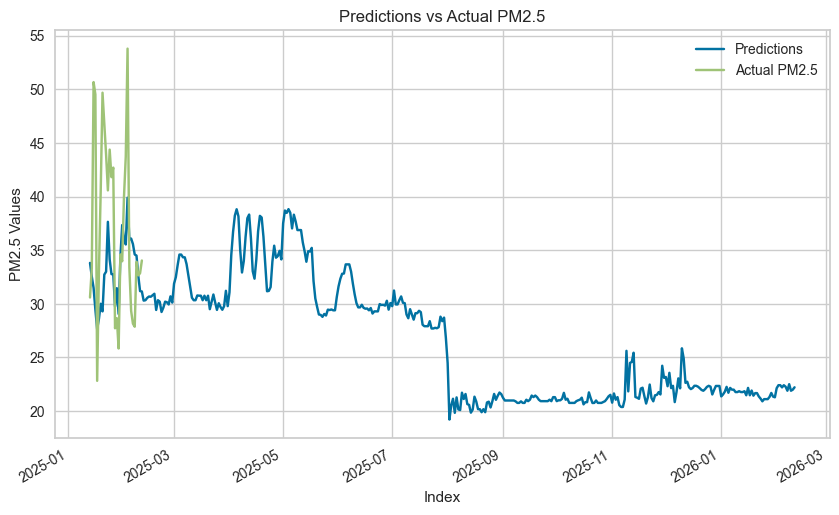

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result_pm_2_5['prediction_label'], real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM2.5']  # ตั้งชื่อคอลัมน์
